# Preprocessing for ML Final

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd
import re
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [2]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GitHub/LFPAnalysis'
#desired subjects
subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
subj_formats = ['edf', 'edf', 'edf', 'edf', 'edf']
subj_site = ['MSSM','MSSM','MSSM','MSSM','MSSM']

# Specify the format being loaded. Probably smart to put subjects and their format in a dataframe. 
anat_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
data_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
ml_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

#dictionaries for data storage
elec_dict = {f'{x}': [] for x in subj_ids}
mne_dict = {f'{x}': [] for x in subj_ids}
photodiode_dict = {f'{x}': [] for x in subj_ids}

In [6]:
### getting mne data and rereferencing to wm - only need to run once! 

for ix, subj_id in enumerate(subj_ids): 
    # Set paths
    load_path = data_path + subj_id
    elec_path = anat_path + subj_id + '_labels.csv'
    save_path = data_path + subj_id
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    # Make MNE file
    mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                             elec_path=elec_path, 
                                             format=subj_formats[ix], #just for now
                                             return_data=True,
                                             site=subj_site[ix])

    # Re-reference neural data
    mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_path, 
                                                  method='wm',
                                                  site=subj_site[ix])

    # Save this data so that you don't need this step again:
    mne_data_reref.save(f'{save_path}/wm_ref_ieeg.fif', overwrite=True)

/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:765: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:796: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA8/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_job

In [12]:
data_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'

for subj_id in subj_ids: 
    # Set paths
    load_path = data_path + subj_id 
    elec_path = anat_path + subj_id + '_labels.csv'
    
    elec_data = lfp_preprocess_utils.load_elec(elec_path)


    mne_data_reref = mne.io.read_raw_fif(f'{load_path}/wm_ref_ieeg.fif', preload=True)

    photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

    # Append to list 
    mne_dict[subj_id].append(mne_data_reref)

    photodiode_dict[subj_id].append(photodiode_data)

    elec_dict[subj_id].append(elec_path)
    

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/2299726648.py:13: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS003/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/2299726648.py:13: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS016/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_r

In [29]:
#sync neural and behavioral data
slopes = {f'{x}': [] for x in subj_ids}
offsets = {f'{x}': [] for x in subj_ids}
heights = []

for subj_id in subj_ids: 
        
    # Load the behavioral timestamps: 

    behav_path = behav_dir + subj_id + '_task_data'
    temp_df = pd.read_csv(behav_path, index_col=None, header=0)
    beh_ts = temp_df['TrialOnset']
    beh_ts = beh_ts[~np.isnan(beh_ts)] 

    # Synchronize to the photodiode or whatever your neural sync signal is
    slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                photodiode_dict[subj_id][0], 
                                                smoothSize=11, windSize=15, height=0.25)

    slopes[subj_id].append(slope)
    offsets[subj_id].append(offset)


11 blocks
...........

found matches for 120 of 171 pulses
10 blocks
..........

found matches for 120 of 157 pulses
10 blocks
..........

found matches for 135 of 160 pulses
8 blocks
........

found matches for 100 of 160 pulses
10 blocks
..........

found matches for 135 of 156 pulses
7 blocks
.......

found matches for 120 of 156 pulses
12 blocks
............

found matches for 150 of 186 pulses
9 blocks
.........

found matches for 120 of 186 pulses


In [53]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]} #changed to preceeding 1 second for SWB

# Note: I am treating the baseline events just like ANY OTHER event

# add behavioral times of interest 
for subj_id in subj_ids:
    
    # Filter behavior to the specific subject
    behav_path = behav_dir + subj_id + '_task_data'
    subj_data = pd.read_csv(behav_path, index_col=None, header=0)
    #subj_data = behav_data[behav_data.participant==subj_id] #salman has behavior in one df 
    
    # Set paths
    data_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/' + subj_id #load path
    ml_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/' + subj_id#save path 
    #load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
    #save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

    epochs_all_evs = {f'{x}': np.nan for x in evs}
    epochs_all_baseline = {f'{x}': np.nan for x in evs}

    for event in evs.keys():
        # Make the epochs. 
        ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{data_path}/wm_ref_ieeg.fif', 
                     elec_path=elec_dict[subj_id][0], 
                     slope=slopes[subj_id][0], offset=offsets[subj_id][0],
                     behav_name=event, behav_times=subj_data[event].values, 
                     ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                     downsamp_factor=2, IED_args=IED_args)

        epochs_all_evs[event] = ev_epochs
        epochs_all_evs[event].save(f'{ml_path}/epoch_{event}.fif', overwrite=True)

/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = mne_data_reref.ch_names
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 10658 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 12150 out of 12150 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.1s finished
/var/folders/xk/q5rxx0ld0hn

In [55]:
# Create a dictionary with the name of the events that you want to pull out of your dataframe, and the time associated with them
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

epochs_all_subjs_all_evs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

for subj_id in subj_ids:
    # Filter behavior to the specific subject
    behav_path = behav_dir + subj_id + '_task_data'
    subj_data = pd.read_csv(behav_path, index_col=None, header=0)
    
    for event in evs.keys():
        
        ml_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/' + subj_id#save path 
        ev_epochs = mne.read_epochs(f'{ml_path}/epoch_{event}.fif', preload=True)
        
        epochs_all_subjs_all_evs[subj_id][event] = ev_epochs
        
        # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

        event_metadata = epochs_all_subjs_all_evs[subj_id][event].metadata.copy()

        event_metadata['ev'] = subj_data['EV'].tolist()
        event_metadata['cr'] = subj_data['CR'].tolist()
        event_metadata['outcome'] = subj_data['Outcome'].tolist()
        event_metadata['rpe'] = subj_data['RPE'].tolist()
        event_metadata['profit'] = subj_data['Profit'].tolist()
        event_metadata['cpe'] = subj_data['CPE'].tolist()
        event_metadata['regret'] = subj_data['regret'].tolist()
        event_metadata['relief'] = subj_data['relief'].tolist()

        epochs_all_subjs_all_evs[subj_id][event].metadata = event_metadata
    

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1266768564.py:15: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/MS003/epoch_TrialOnset.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{ml_path}/epoch_{event}.fif', preload=True)
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1266768564.py:15: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/MS003/epoch_DecisionOnset.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ev_epochs = mne.read_epochs(f'{ml_path}/epoch_{event}.fif', preload=True)
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1266768564.py:15: RuntimeWarning: This filename (/Users/alexandrafink/Documents/GraduateSc

In [61]:
epochs_all_subjs_all_evs

{'MS003': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~69.6 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~162.3 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS016': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~91.1 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~212.4 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS017': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~58.4 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~136.3 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS019': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baselin

## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first

Use the metadata to assign conditions to parse your epochs!

In [58]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}
for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [64]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([4, 120]), num=20)
n_cycles = 4  
sr = epochs_all_subjs_all_evs[subj_id][baseline_ev].info['sfreq'] #prob shouldn't have subject_id in here since not in loop...
buf = 1.0
buf_ix = int(buf*sr)


baseline_power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

In [65]:
# Compute baseline_power
for subj_id in subj_ids:
    event = 'TrialOnset'
    epochs = epochs_all_subjs_all_evs[subj_id][event]
        
    # Let's make sure we only do this for good channels
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    for ch_ix in np.arange(epochs._data.shape[1]): 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                            freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

    baseline_power_epochs[subj_id][event] = temp_pow

 - baseline_power_epochs: a dictionary containing all of your subjects' baseline TFR, with the buffer cropped out

Next, compute the power for the analysis events and BASELINE it using the baseline epochs: 

In [66]:
for subj_id in subj_ids:
    for event in analysis_evs:
                
        epochs = epochs_all_subjs_all_evs[subj_id][event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                               epochs._data.shape[1], len(freqs), 
                               epochs._data.shape[-1]])

        for ch_ix in np.arange(epochs._data.shape[1]): 
            ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
            bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
            good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs, axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                                epochs.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
                                      baseline_power_epochs[subj_id]['TrialOnset'], mode='zscore', baseline_only=False)
        
        zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = epochs_all_subjs_all_evs[subj_id][event].metadata
        
        power_epochs[subj_id][event] = zpow
        

/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:138: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.nanmean(baseline_data, axis=time_axis), axis=ev_axis)
/Users/alexandrafink/opt/anaconda3/envs/LFPAnalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:138: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.nanmean(baseline_data, axis=time_axis), axis=ev_axis)
/Users/alexandrafink/opt/anaconda3/envs/LFPAnalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alexandrafink/Documents/GitHub/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:138: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np

In [67]:
power_epochs[subj_id][event]

<EpochsTFR | time : [0.000000, 5.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 86, ~2.40 GB>

 - power_epochs: a dictionary containing all of your subjects' event TFR, with the buffer cropped out and NORMALIZED with the baseline + event period
 Now, let's compute the average spectrogram over some particular region: hippocampus, in this example 

In [80]:
epochs_dict = epochs_all_subjs_all_evs
baseline_dict = baseline_power_epochs
power_dict = power_epochs

ml_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/'
# load pickle module
import pickle


# create a binary pickle file 
f = open(f'{ml_path}/epochs_epochs.pkl',"wb")

# write the python object (dict) to pickle file
pickle.dump(epochs_dict,f)

# close file
f.close()

#epochs_all_evs[event].save(f'{ml_path}/epoch_{event}.fif', overwrite=True)


In [79]:
epochs_dict

{'MS003': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~69.6 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~162.3 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS016': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~91.1 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~212.4 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS017': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baseline off, ~58.4 MB, data loaded, with metadata,
   'TrialOnset': 150>,
  'DecisionOnset': <EpochsFIF |  150 events (all good), -1 - 5.996 sec, baseline off, ~136.3 MB, data loaded, with metadata,
   'DecisionOnset': 150>},
 'MS019': {'TrialOnset': <EpochsFIF |  150 events (all good), -2 - 0.996 sec, baselin

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1839529883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1839529883.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_27513/1839529883.py:23: SettingWithCopyWarning: 
A value 

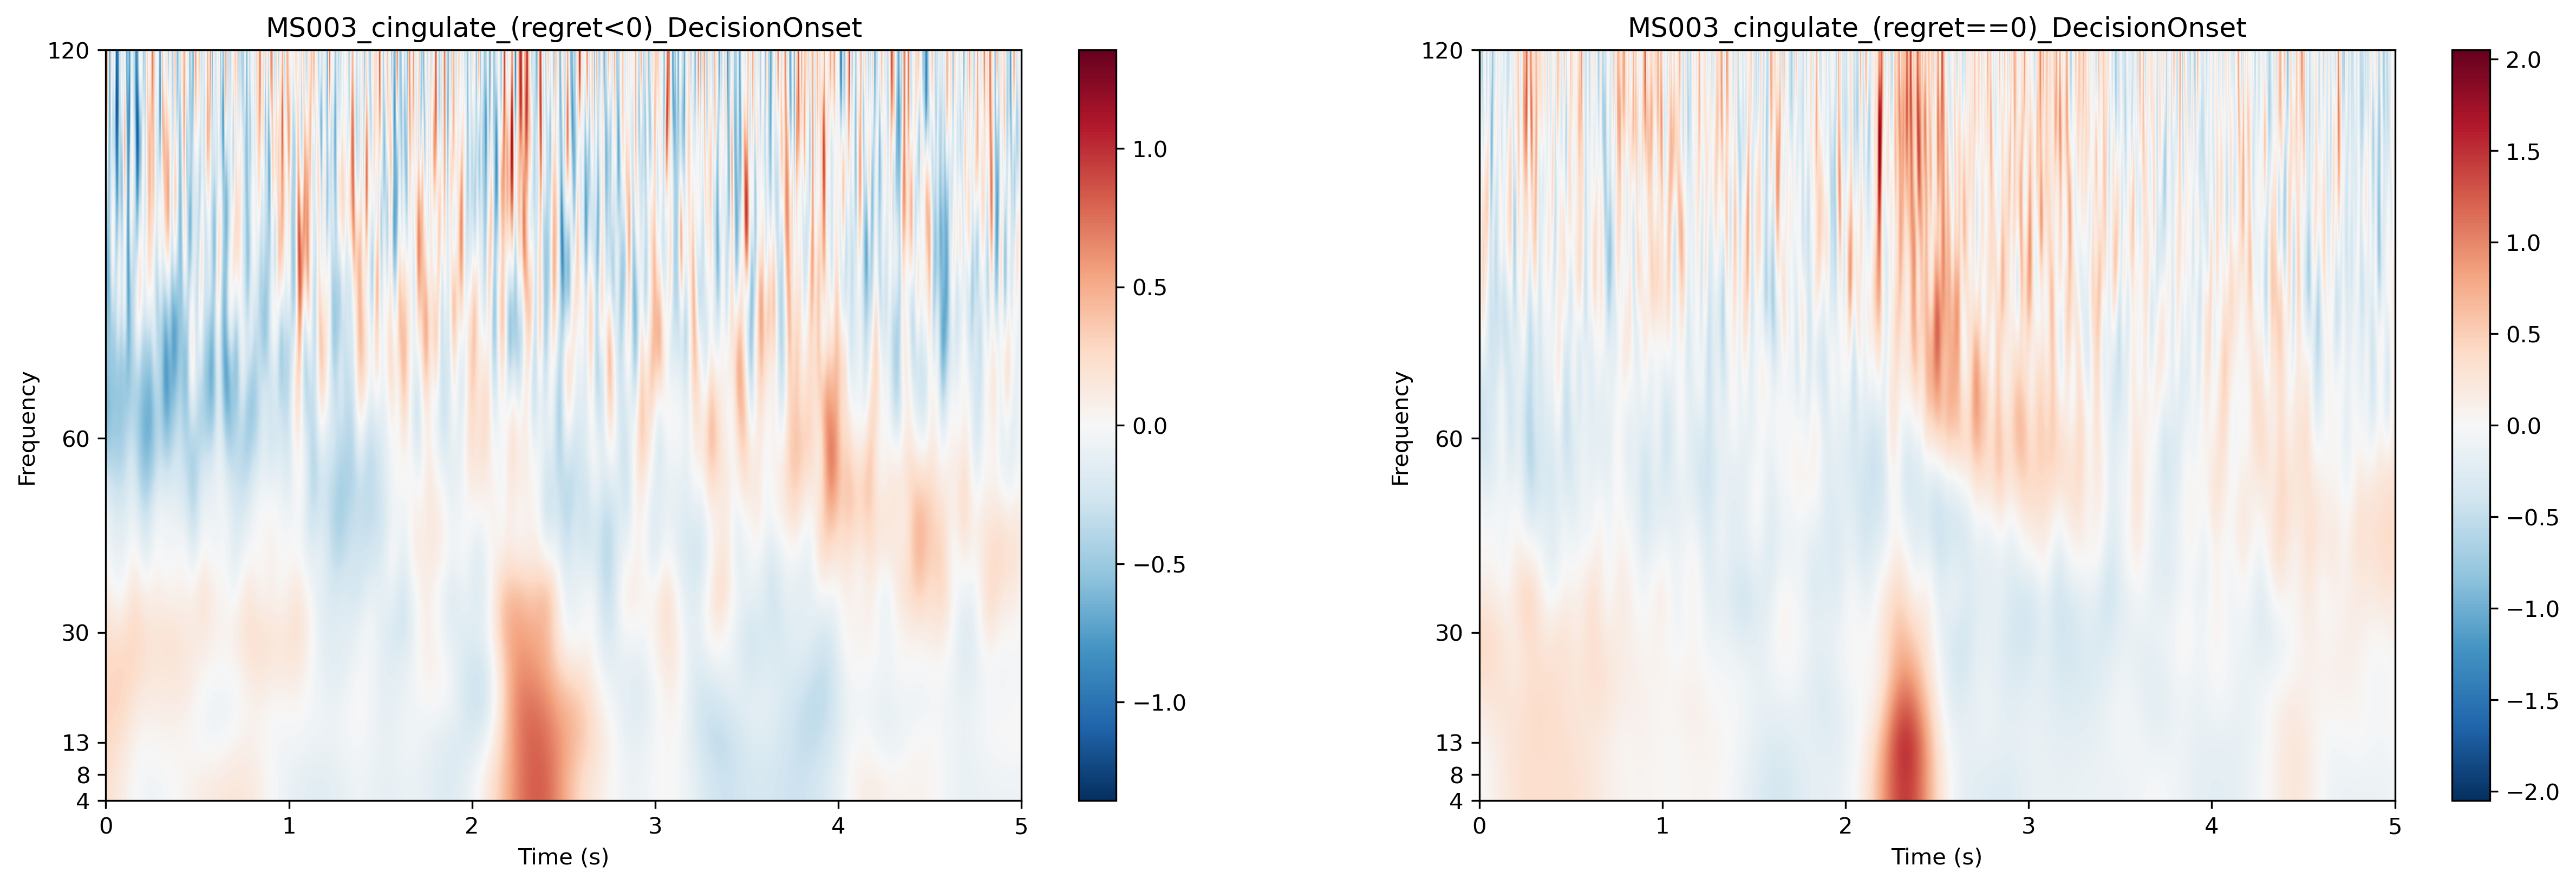

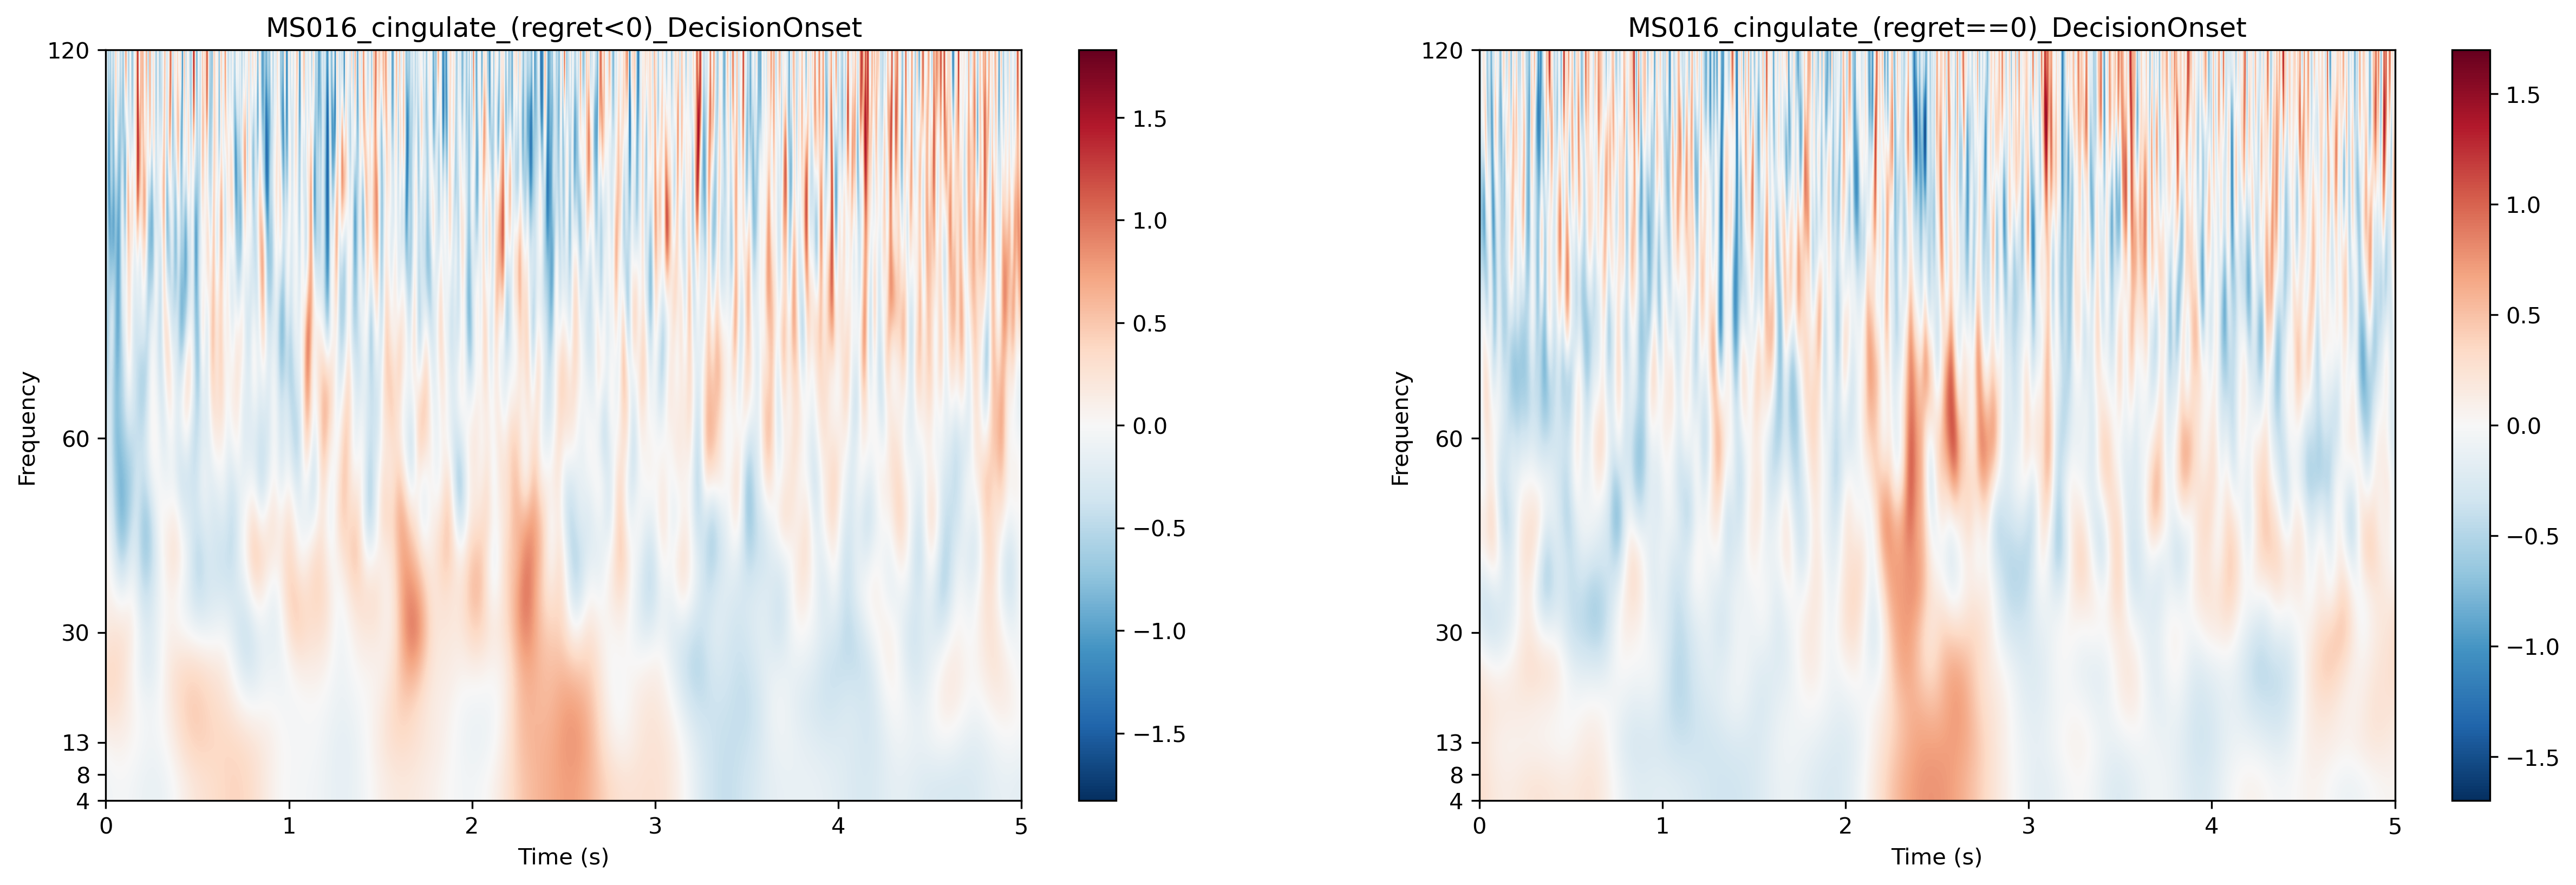

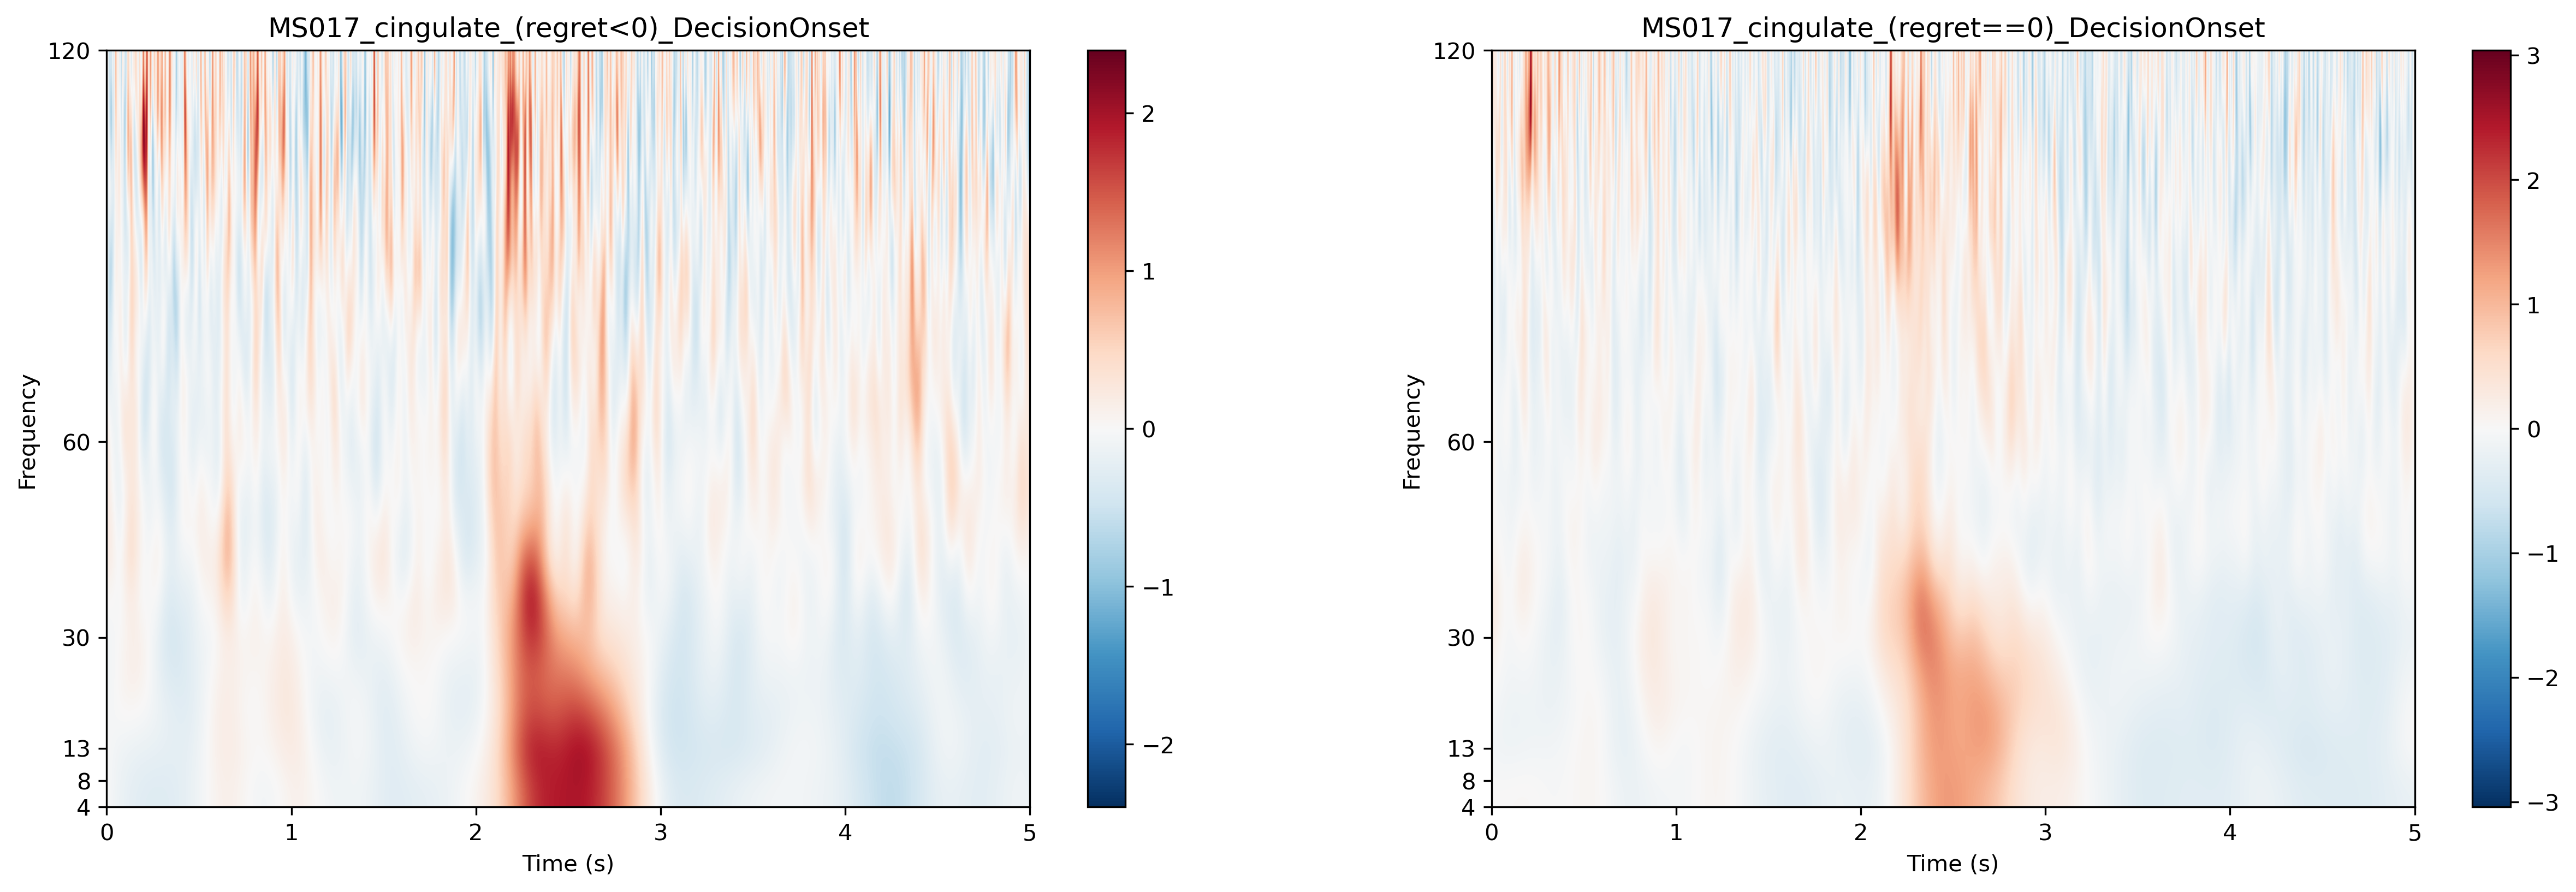

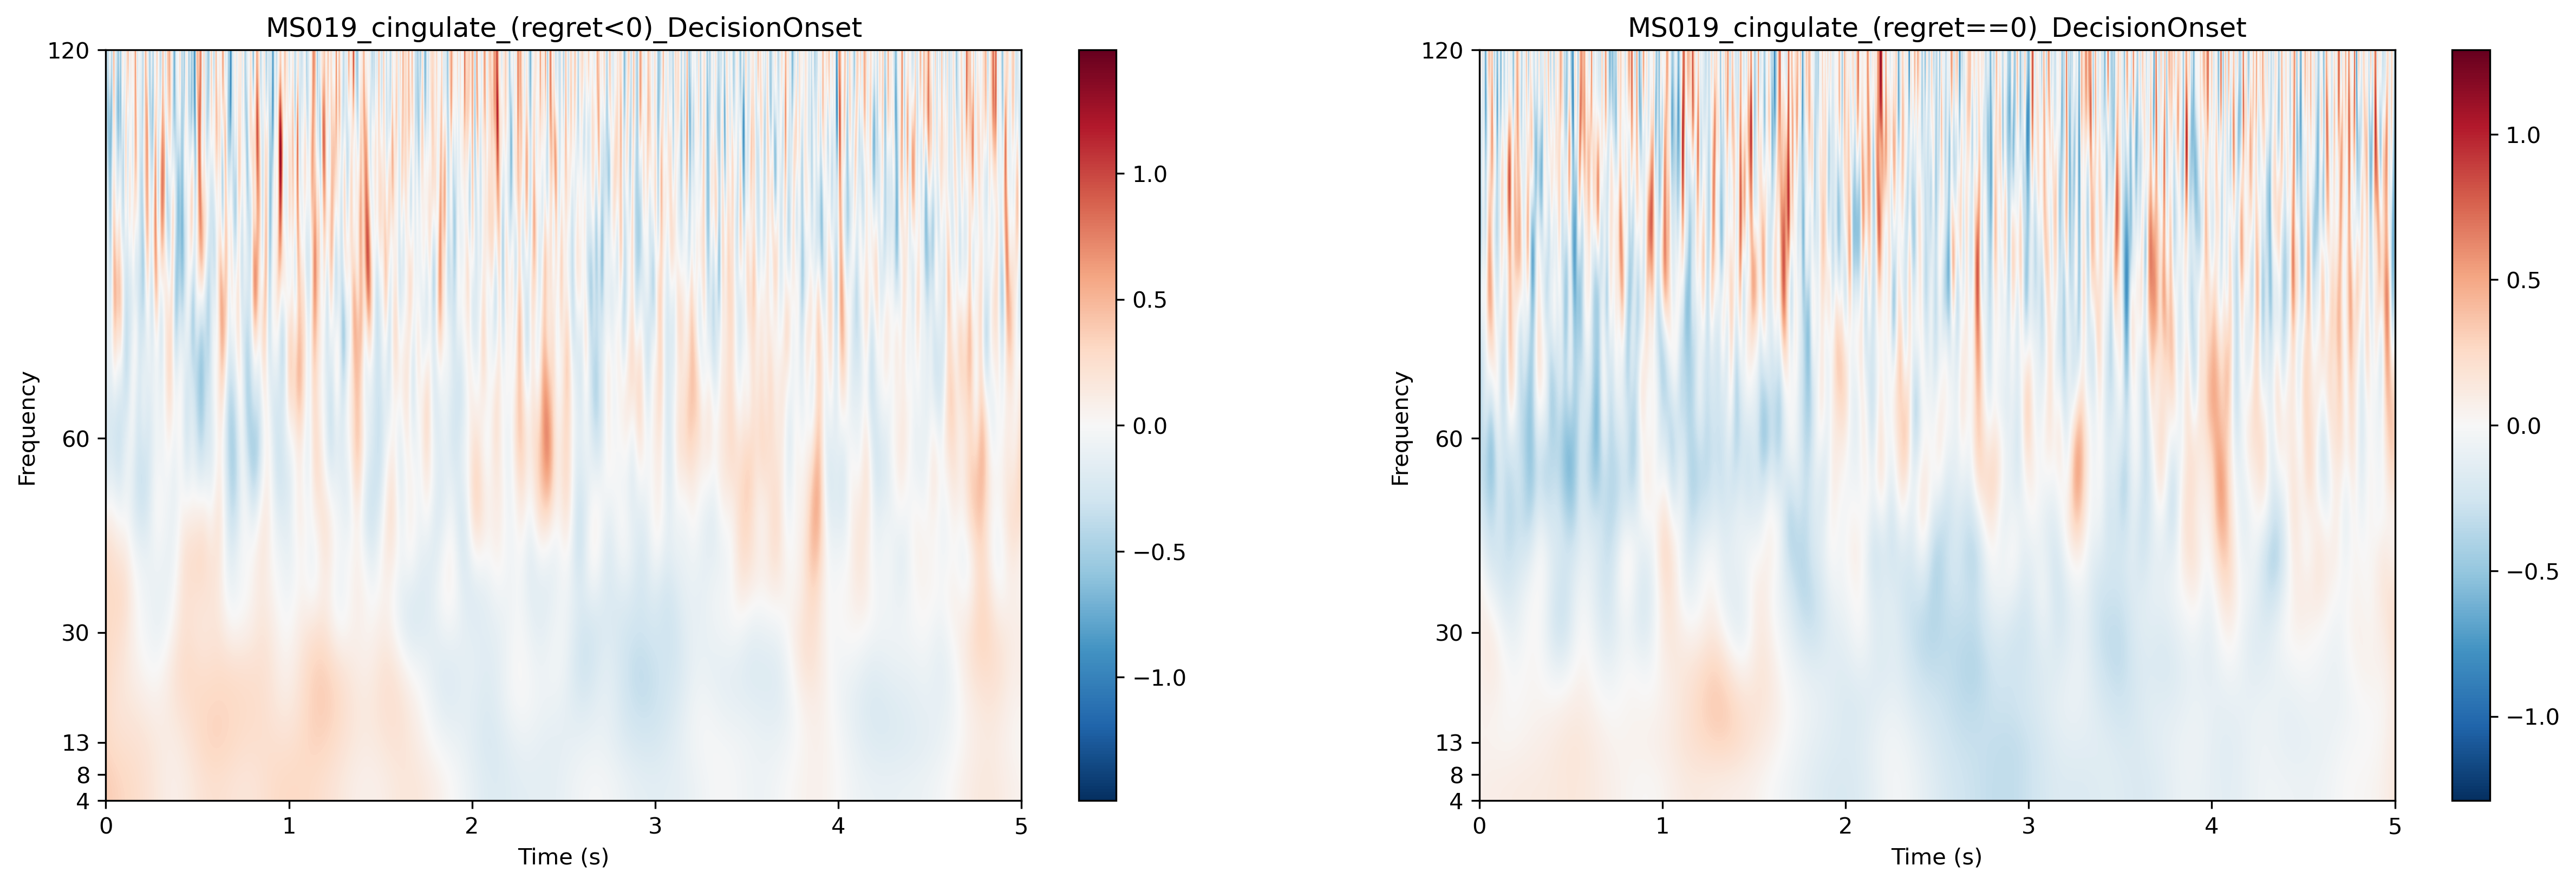

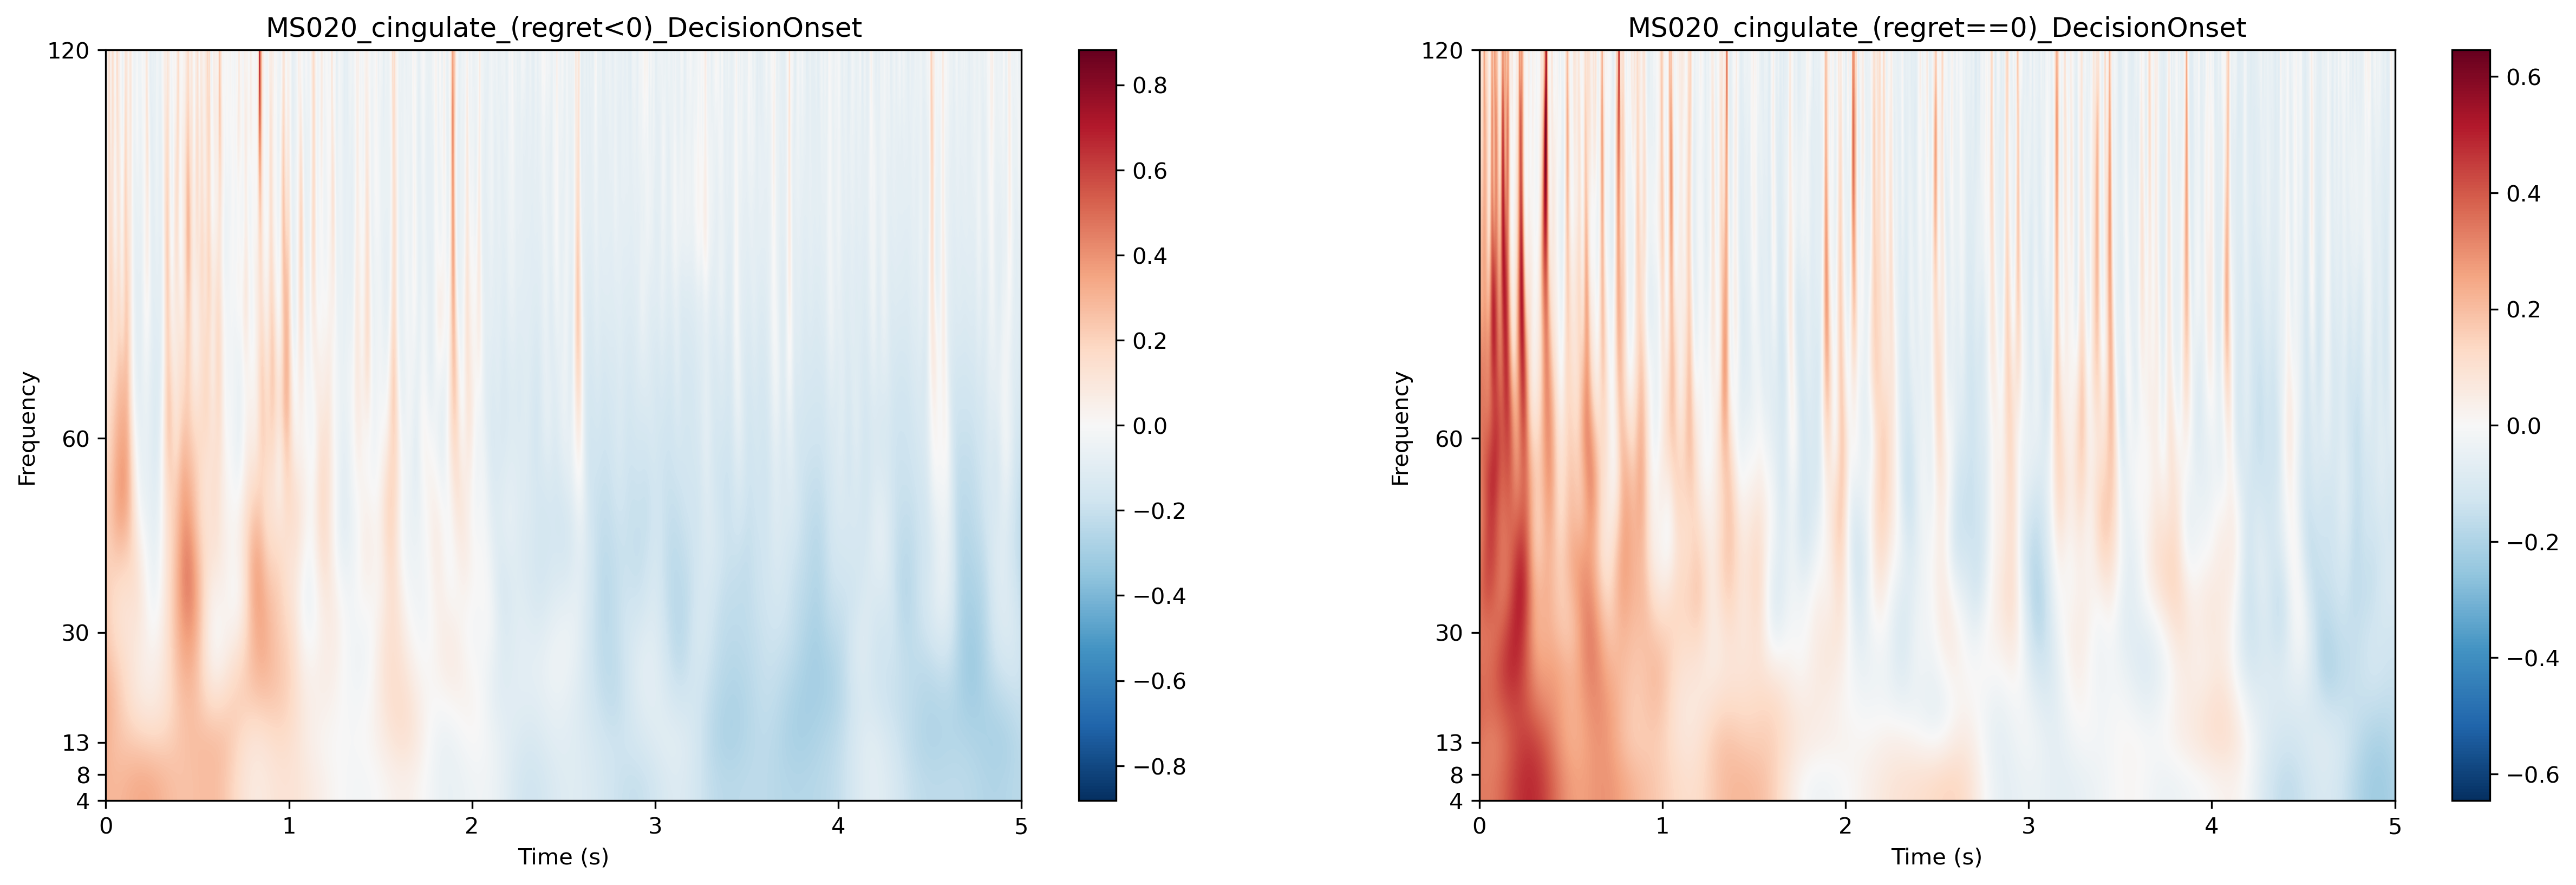

In [72]:
# rois = ['hippocampus', 'amygdala', 'insular', 'cingulate' ,'frontal']
region = 'cingulate'

# band definitions for y-axis
yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 
conditions = ["(regret<0)",
             "(regret==0)"]

cond_name = 'regret'


for subj_id in subj_ids:
    save_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/' + subj_id #save path 
    # Get electrode df 
    elec_file = anat_path + subj_id + '_labels.csv'

    elec_data = lfp_preprocess_utils.load_elec(elec_file)

    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
    elec_data = elec_data.dropna(how='all')

    picks = analysis_utils.select_picks_rois(elec_df, region)
    
    for event in analysis_evs:
        fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
        for ix, cond in enumerate(conditions):
            # Set the times for 
            times = power_epochs[subj_id][event].times
            plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels(picks).data, axis=0), axis=0)

            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
                      aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
            ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{region}_{cond}_{event}')
            fig.colorbar(im, ax=ax[ix])
